# LIB

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import warnings
warnings.filterwarnings(action='ignore')

In [ ]:
import os
import glob
import shutil
import random
import pandas as pd
from PIL import Image
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from collections import Counter, defaultdict
import plotly.express as px
from sklearn.decomposition import PCA
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering
from progressbar import ProgressBar
from sklearn.model_selection import train_test_split as tts
import cv2
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import recall_score

# Dataset and EDA

In [ ]:
files = ['COVID','Normal', 'Lung_Opacity','Viral Pneumonia']
path = "/content/drive/MyDrive/COVID"
data_dir = os.path.join(path)

data = []
for id, level in enumerate(files):
    for file in os.listdir(os.path.join(data_dir, level+'/'+'images')):
#         data.append(['{}/{}'.format(level, file), level])
        data.append([level +'/' +'images'+ '/'+file, level])
        

data = pd.DataFrame(data, columns = ['image_file', 'corona_result'])

data['path'] = path + '/' +data['image_file']
data['corona_result'] = data['corona_result'].map({'Normal': 'Normal', 'COVID': 'Covid_positive', 'Lung_Opacity':'Lung_Opacity', 'Viral Pneumonia':'Viral_Pneumonia'})

# data.head() 
data

,image_file,corona_result,path
0,COVID/images/COVID-3353.png,Covid_positive,/content/drive/MyDrive/COVID/COVID/images/COVI...
1,COVID/images/COVID-3351.png,Covid_positive,/content/drive/MyDrive/COVID/COVID/images/COVI...
2,COVID/images/COVID-3354.png,Covid_positive,/content/drive/MyDrive/COVID/COVID/images/COVI...
3,COVID/images/COVID-3360.png,Covid_positive,/content/drive/MyDrive/COVID/COVID/images/COVI...
4,COVID/images/COVID-3331.png,Covid_positive,/content/drive/MyDrive/COVID/COVID/images/COVI...
...,...,...,...
21170,Viral Pneumonia/images/Viral Pneumonia-1304.png,Viral_Pneumonia,/content/drive/MyDrive/COVID/Viral Pneumonia/i...
21171,Viral Pneumonia/images/Viral Pneumonia-1307.png,Viral_Pneumonia,/content/drive/MyDrive/COVID/Viral Pneumonia/i...
21172,Viral Pneumonia/images/Viral Pneumonia-1295.png,Viral_Pneumonia,/content/drive/MyDrive/COVID/Viral Pneumonia/i...
21173,Viral Pneumonia/images/Viral Pneumonia-1309.png,Viral_Pneumonia,/content/drive/MyDrive/COVID/Viral Pneumonia/i...


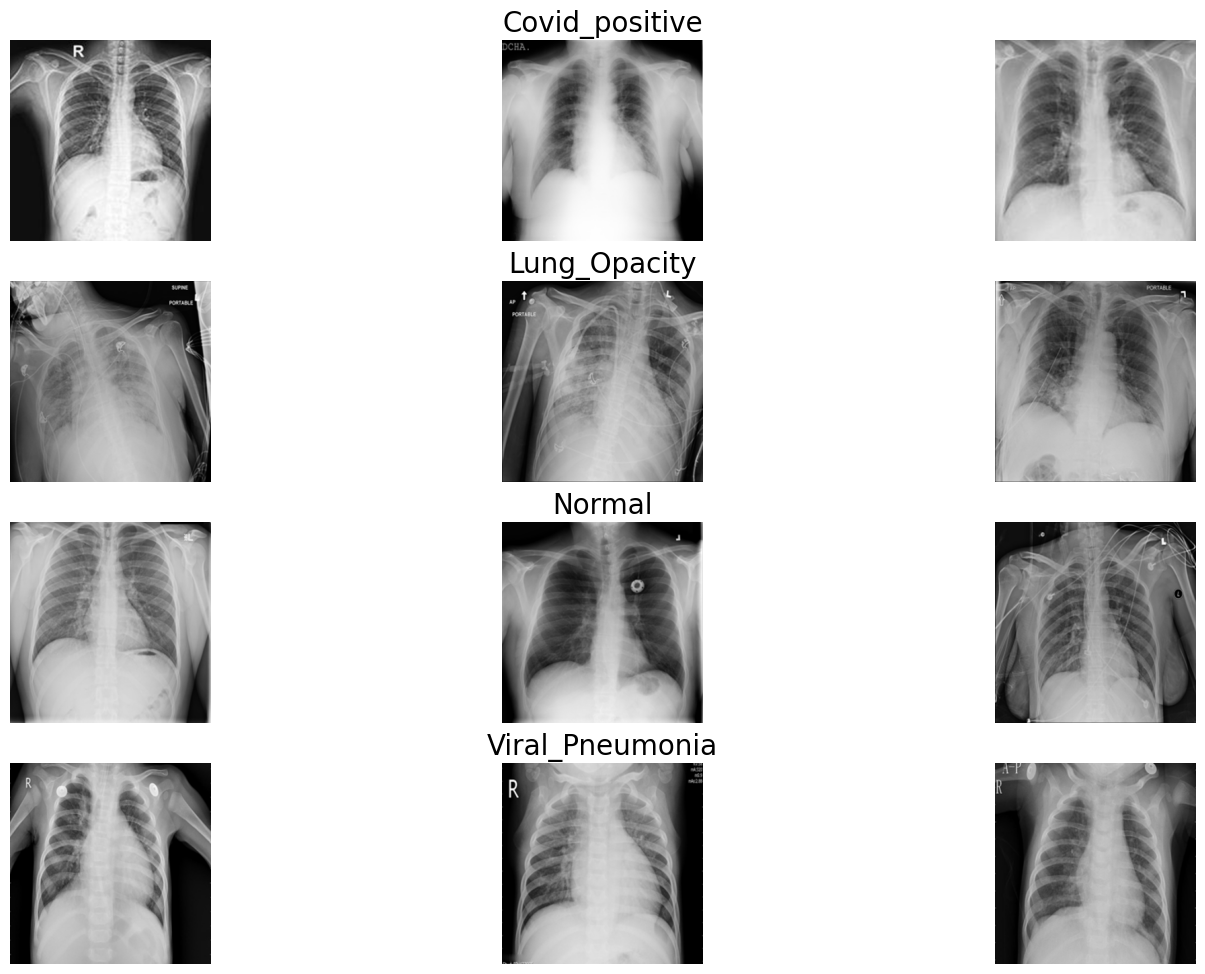

In [ ]:
n_samples = 3

fig, m_axs = plt.subplots(4, n_samples, figsize = (6*3, 3*4))

for n_axs, (type_name, type_rows) in zip(m_axs, data.sort_values(['corona_result']).groupby('corona_result')):
    n_axs[1].set_title(type_name, fontsize = 20)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(3, random_state = 1234).iterrows()):       
        picture = c_row['path']
        image = cv2.imread(picture)
        c_ax.imshow(image)
        c_ax.axis('off')

In [ ]:
print('Normal : ', list(data['corona_result']).count('Normal'))
print('Covid : ', list(data['corona_result']).count('Covid_positive'))
print('Opacity : ', list(data['corona_result']).count('Lung_Opacity'))
print('VIral Pneumonia : ', list(data['corona_result']).count('Viral_Pneumonia'))

Normal :  10202
Covid :  3616
Opacity :  6012
VIral Pneumonia :  1345


In [ ]:
no_of_samples = 21165
df = pd.DataFrame()
df['corona_result'] = ['Normal', 'Covid_positive', 'Lung_Opacity', 'Viral_Pneumonia']
df['Count'] = [10202,3616,6012,1345]
fig = px.bar(df, x = 'corona_result', y = 'Count', 
             color = "corona_result",  width = 600, 
             color_continuous_scale='BrBg')
fig.show()

In [ ]:
from tqdm import tqdm
from PIL import Image, ImageOps

pixel_img = []

for image in tqdm(data['path']):
    img=Image.open(image)
    img=ImageOps.grayscale(img)
    img=img.resize((50,50))
    img=np.asarray(img)
    img=img.reshape((50,50,1))
    img=img.flatten()
    pixel_img.append(img)

100%|██████████| 21175/21175 [01:35<00:00, 222.09it/s]


In [ ]:
pixel_img = np.array(pixel_img)
lbls = data['corona_result'].map({'Normal': 0, 'Covid_positive': 1, 'Lung_Opacity' : 0,
                               'Viral_Pneumonia' : 0})

In [ ]:
print(pixel_img.shape)
print(lbls.shape)

(21175, 2500)
(21175,)


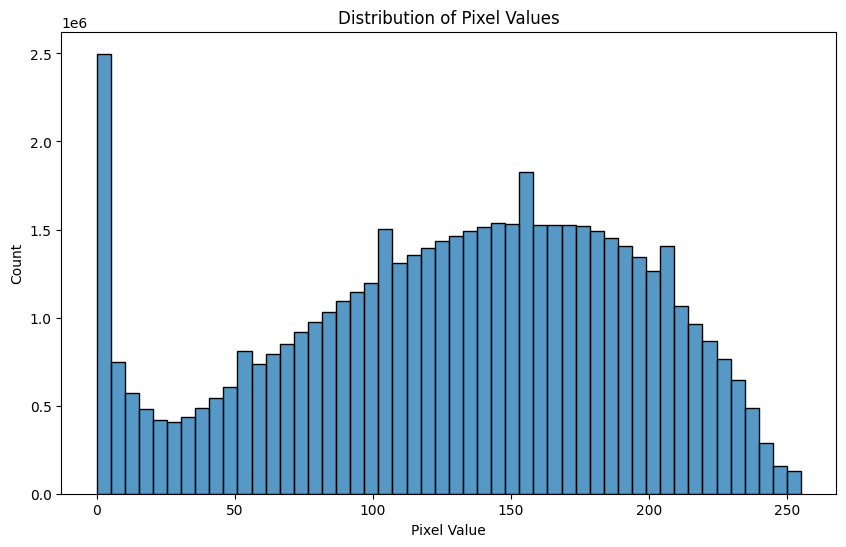

In [ ]:
plt.figure(figsize=(10,6))
sns.histplot(pixel_img.flatten(), kde=False, bins=50)
plt.title('Distribution of Pixel Values')
plt.xlabel('Pixel Value')
plt.ylabel('Count')
plt.show()

In [ ]:
scaler=StandardScaler()
imgs = scaler.fit(pixel_img).transform(pixel_img)

In [ ]:
imgs

array([[-0.73251445, -0.67166267, -0.67097254, ..., -0.73748719,
        -0.55798912, -0.51779329],
       [-0.32535953, -0.69291334, -0.7132386 , ..., -0.58696647,
        -0.84612757,  0.18049518],
       [ 1.36142518,  1.538407  ,  1.65366105, ...,  0.08353488,
         0.23439161,  0.25478118],
       ...,
       [-0.55801949,  1.00714025,  1.27326646, ..., -0.8743242 ,
        -0.86053449, -0.85950892],
       [-0.09269957,  0.43337216,  1.1042022 , ..., -0.929059  ,
        -0.81731372, -0.80008011],
       [ 0.99304691,  1.1133936 ,  0.99853704, ..., -0.9701101 ,
        -0.83172065, -0.81493732]])

In [ ]:
imgs_train,imgs_test,lbls_train,lbls_test=tts(imgs,lbls,test_size=0.3)

In [ ]:
imgs_train.shape, imgs_test.shape

((14822, 2500), (6353, 2500))

In [ ]:
lbls_train=np.array(lbls_train)
lbls_test=np.array(lbls_test)

<Axes: xlabel='corona_result', ylabel='Count'>

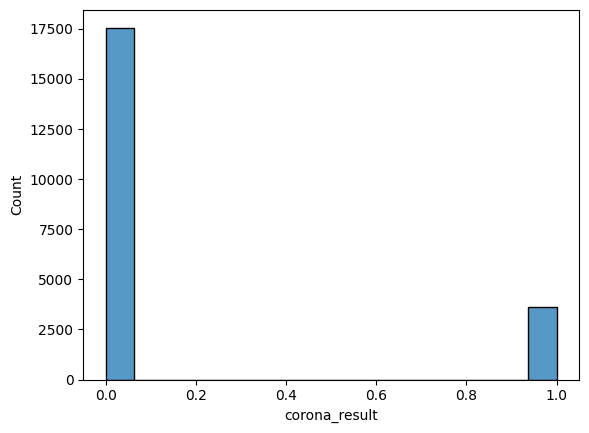

In [ ]:
sns.histplot(lbls)

# Anomaly Detection

In [ ]:
k=len(imgs_train[:,0])**(0.5)
k=int(k)
k

121

In [ ]:
nbrs=NearestNeighbors(n_neighbors=k)
nbrs.fit(imgs_train)

NearestNeighbors(n_neighbors=121)

In [ ]:
dists,_=nbrs.kneighbors(imgs_train)

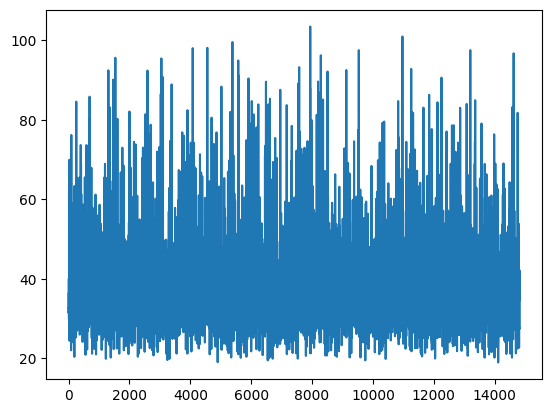

In [ ]:
plt.plot(dists.mean(axis=1))

In [ ]:
d = 55
anoms=np.where(dists.mean(axis=1) > d)[0]
print(len(anoms))

438


anomaly removal

In [ ]:
anoms

array([   12,    26,    40,    43,    88,   118,   189,   251,   288,
         360,   397,   407,   414,   477,   532,   586,   629,   658,
         675,   688,   747,   748,   760,   775,   812,   866,   884,
         896,   952,  1017,  1172,  1176,  1194,  1195,  1235,  1276,
        1300,  1306,  1340,  1352,  1394,  1416,  1449,  1461,  1486,
        1524,  1532,  1535,  1603,  1712,  1751,  1765,  1766,  1806,
        1999,  2039,  2110,  2147,  2158,  2201,  2255,  2423,  2440,
        2443,  2489,  2493,  2526,  2530,  2542,  2591,  2615,  2657,
        2669,  2676,  2679,  2691,  2695,  2717,  2759,  2774,  2860,
        2889,  2893,  2910,  2973,  2981,  2983,  3028,  3048,  3072,
        3087,  3089,  3090,  3101,  3292,  3304,  3308,  3317,  3334,
        3364,  3383,  3384,  3498,  3534,  3601,  3621,  3648,  3735,
        3784,  3792,  3822,  3850,  3907,  3909,  3910,  3912,  3921,
        3974,  3999,  4011,  4013,  4071,  4078,  4103,  4106,  4118,
        4126,  4129,

In [ ]:
imgs_par=[]
lbls_par=[]
for i in range(len(imgs_train[:,0])):
  if i not in anoms:
    imgs_par.append(imgs_train[i])
    lbls_par.append(lbls_train[i])
imgs_par=np.array(imgs_par)
lbls_par=np.array(lbls_par)

# PCA

determining optimal no. of principle components

In [ ]:
def pca_variance_plot(x):
  pca=PCA()
  x_pca=pca.fit_transform(x)
  exp_var_pca = pca.explained_variance_ratio_
  plt.plot(range(0,25), [exp_var_pca[i] for i in range(25)], label='Individual explained variance')
  plt.ylabel('Explained variance ratio')
  plt.xlabel('Principal component index')
  plt.legend(loc='best')
  plt.show()

In [ ]:
def pca_on_dataset(x,n):
  pca=PCA(n_components=n)
  return(pca.fit(x).transform(x))

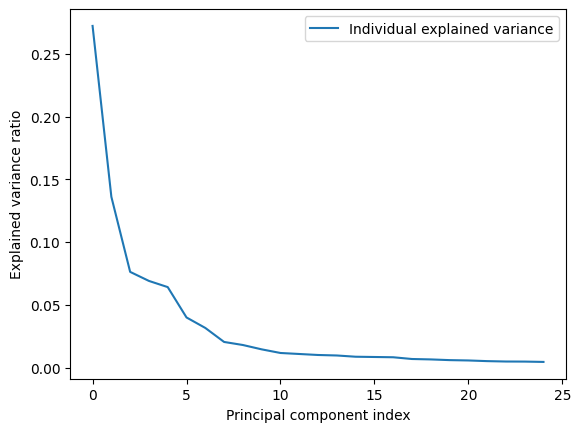

In [ ]:
pca_variance_plot(imgs_par)

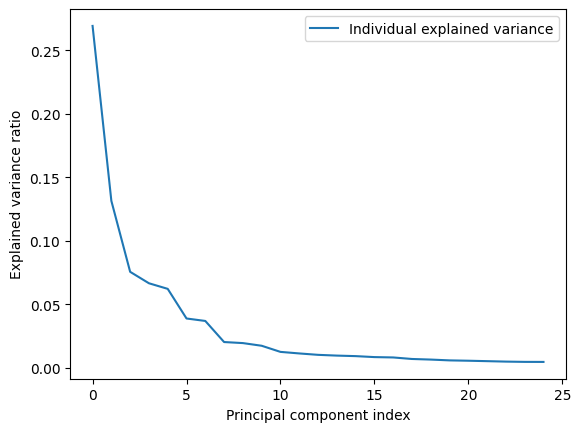

In [ ]:
pca_variance_plot(imgs)

In [ ]:
n_pc=10
n_pc_par=10

In [ ]:
imgs_train_pca=pca_on_dataset(imgs_train,n_pc)

In [ ]:
imgs_par_pca=pca_on_dataset(imgs_par,n_pc_par)

In [ ]:
imgs_test_pca=pca_on_dataset(imgs_test,n_pc)

#Model Selection

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.neural_network import MLPClassifier
import lightgbm
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier,AdaBoostClassifier
from xgboost import XGBClassifier
import cv2

In [ ]:
def validation_on_models(models, X, y):
    X_train, X_val, y_train, y_val = tts(X, y, train_size=0.85)
    acc_results = []
    recall_results = []
    model_names = []
    for name, model in models.items():
        model.fit(X_train, y_train)
        print(name + " trained")
        result = model.score(X_val, y_val)
        recall = recall_score(y_val, model.predict(X_val))
        acc_results.append(result)
        recall_results.append(recall)
        model_names.append(name)
        print(name + ": accuracy->{:.2f}% recall->{:.2f}%".format(result * 100 , recall*100))
    # plot results
    x = np.arange(len(model_names))
    width = 0.35
    fig, ax = plt.subplots()
    ax.bar(x - width/2, acc_results, width, label='Accuracy')
    ax.bar(x + width/2, recall_results, width, label='Recall')
    ax.set_xticks(x)
    ax.set_xticklabels(model_names, rotation=45, ha='right')
    ax.legend()
    plt.show()

In [ ]:
models = {
    "                   Logistic Regression": LogisticRegression(),
    "                   K-Nearest Neighbors": KNeighborsClassifier(),
    "                         Decision Tree": DecisionTreeClassifier(),
    "Support Vector Machine (Linear Kernel)": LinearSVC(),
    "   Support Vector Machine (RBF Kernel)": SVC(),
    "                        Neural Network": MLPClassifier(),
    "                         Random Forest": RandomForestClassifier(),
    "                     Gradient Boosting": GradientBoostingClassifier(),
    "                   XG Boost Classifier": XGBClassifier(),
    "                  Ada Boost Classifier": AdaBoostClassifier(),
    "                   LightGBM Classifier": LGBMClassifier()
}

In [ ]:
validation_on_models(models,imgs_train,lbls_train)

                   Logistic Regression trained
                   Logistic Regression: accuracy->85.40% recall->40.27%
                   K-Nearest Neighbors trained
                   K-Nearest Neighbors: accuracy->90.08% recall->49.59%
                         Decision Tree trained
                         Decision Tree: accuracy->87.30% recall->61.37%
Support Vector Machine (Linear Kernel) trained
Support Vector Machine (Linear Kernel): accuracy->81.14% recall->51.23%
   Support Vector Machine (RBF Kernel) trained
   Support Vector Machine (RBF Kernel): accuracy->93.19% recall->62.19%
                        Neural Network trained
                        Neural Network: accuracy->91.80% recall->74.52%
                         Random Forest trained
                         Random Forest: accuracy->91.94% recall->54.52%
                     Gradient Boosting trained
                     Gradient Boosting: accuracy->91.43% recall->54.79%
                   XG Boost Classifier trained
 

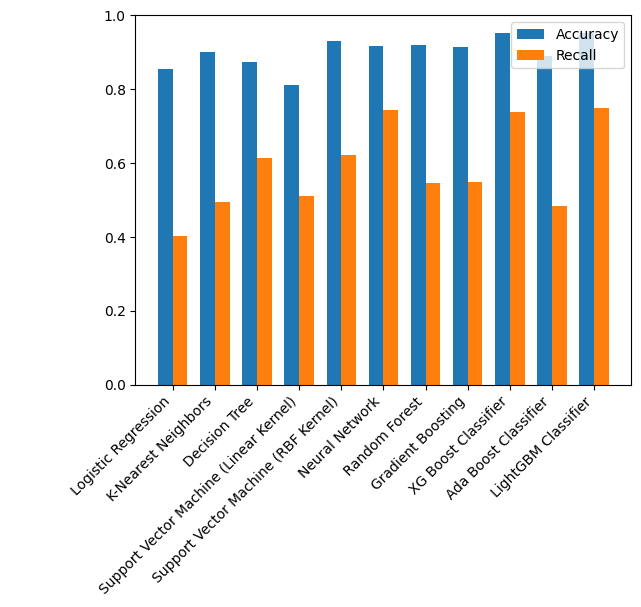

In [ ]:
validation_on_models(models,imgs_par,lbls_par)

#Feature Selection

In [ ]:
# pip install joblib

In [ ]:
# pip install mlxtend --upgrade --no-deps

In [ ]:
# import joblib
# from mlxtend.feature_selection import SequentialFeatureSelector as SFS
# from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

In [ ]:
# xgb = XGBClassifier()
# xgb.fit(imgs_par_pca, lbls_par)

In [ ]:
# sfs = SFS(xgb, forward=False, floating=True, scoring='recall')
# sfs = sfs.fit(imgs_par, lbls_par)

In [ ]:
# print('Accuracy:', sfs.k_score_)
# print('Number of features:', len([list(sfs.k_feature_idx_)]))

In [ ]:
from sklearn.feature_selection import SelectFromModel
xgb = XGBClassifier()
xgb.fit(imgs_par_pca, lbls_par)
model = SelectFromModel(xgb, prefit=True)
X_selected = model.transform(imgs_par_pca)
X_selected.shape

(14384, 3)

In [ ]:
X_train,X_val,y_train,y_val=tts(X_selected, lbls_par,train_size=0.85)

In [ ]:
xgb_1 = XGBClassifier()
xgb_1.fit(X_train, y_train)
result = xgb_1.score(X_val,y_val)
recall = recall_score(y_val,xgb_1.predict(X_val))

In [ ]:
result, recall

(0.8470806302131604, 0.2703488372093023)

# Hyperparameter Tuning

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, recall_score

In [ ]:
X_train_par,X_val_par,y_train_par,y_val_par=tts(imgs_par,lbls_par,train_size=0.85)

In [ ]:
xgb_tuned = XGBClassifier()
param_distributions = {
    'max_depth': [3, 5, 7, 9],
    'subsample': [0.5, 0.7, 1],
    'colsample_bytree': [0.5, 0.7, 1],
    'gamma': [0, 1, 5, 10],
    'reg_lambda': [0, 0.1, 0.5, 1]
}

recall_scorer = make_scorer(recall_score)

random_search = RandomizedSearchCV(
    xgb_tuned,
    param_distributions=param_distributions,
    scoring=recall_scorer,
    verbose=3,
    n_jobs=-1
)

random_search.fit(X_train_par,y_train_par)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None...
                                           max_leaves=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           predictor=None, random_state=None, ...),
                   n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.5, 0.7, 1],
                                        'gamma': [0, 1, 5, 10],
                                        'max_depth': [3, 5, 7, 9],
                                        'reg_lambda': [0, 0.1, 0.5, 1],
                                        'subsample': [0.5, 0.7, 1]},
                   scoring=make_scorer(recall_score), verbose=3)

In [ ]:
best_model = random_search.best_estimator_

y_pred = best_model.predict(X_val_par)
best_model.score(X_val_par,y_val_par)
recall = recall_score(y_val_par, y_pred)

print('Best model recall:', recall)
print(best_model.score(X_val_par,y_val_par))

Best model recall: 0.76
0.9531974050046339


# CNN

In [ ]:
from tqdm import tqdm
from PIL import Image, ImageOps

pi_cnn = []

for image in tqdm(data['path']):
    img=Image.open(image)
    img=ImageOps.grayscale(img)
    img=img.resize((50,50))
    img=np.asarray(img)
    img=img.reshape((50,50,1))
    pi_cnn.append(img)

100%|██████████| 21175/21175 [1:35:20<00:00,  3.70it/s]


In [ ]:
pi_cnn = np.array(pi_cnn)
lbls_cnn = data['corona_result'].map({'Normal': 0, 'Covid_positive': 1, 'Lung_Opacity' : 0,
                               'Viral_Pneumonia' : 0})

In [ ]:
pi_cnn.shape


(21175, 50, 50, 1)

In [ ]:
(img_train_cnn, img_test_cnn, lbls_train_cnn, lbls_test_cnn) = tts(pi_cnn, lbls_cnn,test_size=0.30,random_state=42)

trainX = np.array(img_train_cnn)
testX = np.array(img_test_cnn)
trainY = np.array(lbls_train_cnn)
testY = np.array(lbls_test_cnn)

In [ ]:
print(img_train_cnn.shape, img_test_cnn.shape, lbls_train_cnn.shape, lbls_test_cnn.shape)

(14822, 50, 50, 1) (6353, 50, 50, 1) (14822,) (6353,)


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(50,50,1)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(trainX, trainY, epochs=10, validation_data=(testX, testY))
test_loss, test_acc = model.evaluate(testX, testY)
print('Test accuracy:', test_acc)
predictions = model.predict(testX)
binary_predictions = (predictions > 0.5).astype(int)
print(classification_report(testY, binary_predictions))

Epoch 1/10
464/464 [==============================] - 77s 154ms/step - loss: 0.7278 - accuracy: 0.8454 - val_loss: 0.2668 - val_accuracy: 0.8837
Epoch 2/10
464/464 [==============================] - 61s 132ms/step - loss: 0.2590 - accuracy: 0.8877 - val_loss: 0.2205 - val_accuracy: 0.9076
Epoch 3/10
464/464 [==============================] - 80s 172ms/step - loss: 0.2129 - accuracy: 0.9097 - val_loss: 0.2052 - val_accuracy: 0.9167
Epoch 4/10
464/464 [==============================] - 63s 136ms/step - loss: 0.1948 - accuracy: 0.9209 - val_loss: 0.1928 - val_accuracy: 0.9226
Epoch 5/10
464/464 [==============================] - 62s 133ms/step - loss: 0.1657 - accuracy: 0.9329 - val_loss: 0.1823 - val_accuracy: 0.9281
Epoch 6/10
464/464 [==============================] - 71s 154ms/step - loss: 0.1421 - accuracy: 0.9416 - val_loss: 0.2572 - val_accuracy: 0.8980
Epoch 7/10
464/464 [==============================] - 66s 142ms/step - loss: 0.1210 - accuracy: 0.9532 - val_loss: 0.1623 - val_ac

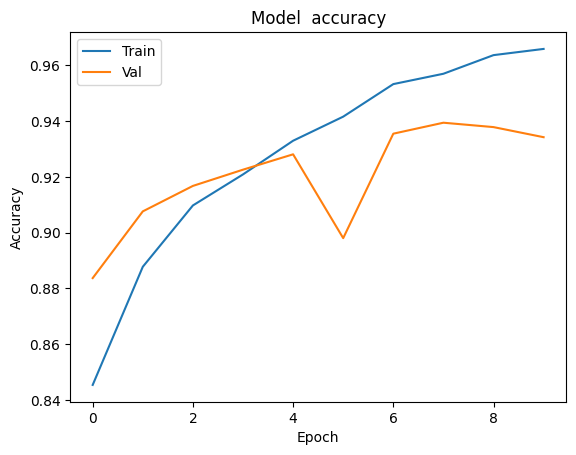

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model  accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras import models
# Define the hyperparameters to tune
param_grid = {
    'filters': [32, 64],
    'kernel_size': [(3,3), (5,5)],
    'activation': ['relu', 'sigmoid'],
}

# Define a function to build and compile the CNN model with the specified hyperparameters
def build_model(filters, kernel_size, activation, neurons = 32, learning_rate = 0.1):
    model = models.Sequential([
        layers.Conv2D(filters, kernel_size, activation=activation, input_shape=(50,50,1)),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(filters, kernel_size, activation=activation),
        layers.MaxPooling2D((2,2)),
        layers.Flatten(),
        layers.Dense(neurons, activation=activation),
        layers.Dense(1, activation='sigmoid')
    ])
    optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.Recall()])
    return model

# Create the GridSearchCV object with the hyperparameters to tune and the build_model function
grid_search = GridSearchCV(estimator=KerasClassifier(build_fn=build_model, epochs=10, validation_data=(testX, testY)), param_grid=param_grid, scoring='recall', verbose=1)

# Train the CNN model with the hyperparameters defined in param_grid and evaluate its performance on the validation set
grid_search.fit(trainX, trainY)

# Print the best hyperparameters and the corresponding recall score
print("Best hyperparameters:", grid_search.best_params_)
print("Best recall score:", grid_search.best_score_)

# Use the best hyperparameters to retrain the model on the entire training set
best_model = build_model(filters=grid_search.best_params_['filters'], kernel_size=grid_search.best_params_['kernel_size'], activation=grid_search.best_params_['activation'], neurons=grid_search.best_params_['neurons'], learning_rate=grid_search.best_params_['learning_rate'])
best_model.fit(trainX, trainY, epochs=10)

# Evaluate the performance of the final model on the test set
test_loss, test_acc, test_recall = best_model.evaluate(testX, testY)
print('Test accuracy:', test_acc)
print('Test recall:', test_recall)


Fitting 5 folds for each of 8 candidates, totalling 40 fits


Epoch 1/10
371/371 [==============================] - 54s 137ms/step - loss: 0.9133 - accuracy: 0.8279 - recall_13: 0.1236 - val_loss: 0.3300 - val_accuracy: 0.8405 - val_recall_13: 0.5620
Epoch 2/10
371/371 [==============================] - 43s 115ms/step - loss: 0.2995 - accuracy: 0.8654 - recall_13: 0.4495 - val_loss: 0.2853 - val_accuracy: 0.8730 - val_recall_13: 0.5111
Epoch 3/10
371/371 [==============================] - 42s 115ms/step - loss: 0.2519 - accuracy: 0.8912 - recall_13: 0.5702 - val_loss: 0.3140 - val_accuracy: 0.8752 - val_recall_13: 0.3139
Epoch 4/10
371/371 [==============================] - 42s 112ms/step - loss: 0.2293 - accuracy: 0.9026 - recall_13: 0.6347 - val_loss: 0.2445 - val_accuracy: 0.8969 - val_recall_13: 0.5574
Epoch 5/10
371/371 [==============================] - 44s 119ms/step - loss: 0.2162 - accuracy: 0.9064 - recall_13: 0.6273 - val_loss: 0.2554 - val_accuracy: 0.8978 - val_recall_13: 0.5194
Epoch 6/10
371/371 [==============================] - 4

Epoch 1/10
371/371 [==============================] - 42s 111ms/step - loss: 0.6398 - accuracy: 0.8376 - recall_14: 0.2298 - val_loss: 0.3380 - val_accuracy: 0.8575 - val_recall_14: 0.2315
Epoch 2/10
371/371 [==============================] - 43s 116ms/step - loss: 0.2955 - accuracy: 0.8698 - recall_14: 0.4337 - val_loss: 0.2949 - val_accuracy: 0.8689 - val_recall_14: 0.3315
Epoch 3/10
371/371 [==============================] - 45s 122ms/step - loss: 0.2564 - accuracy: 0.8901 - recall_14: 0.5578 - val_loss: 0.3189 - val_accuracy: 0.8588 - val_recall_14: 0.1889
Epoch 4/10
371/371 [==============================] - 45s 122ms/step - loss: 0.2285 - accuracy: 0.9021 - recall_14: 0.6144 - val_loss: 0.2188 - val_accuracy: 0.9082 - val_recall_14: 0.6537
Epoch 5/10
371/371 [==============================] - 45s 123ms/step - loss: 0.2120 - accuracy: 0.9113 - recall_14: 0.6670 - val_loss: 0.2387 - val_accuracy: 0.9024 - val_recall_14: 0.5769
Epoch 6/10
371/371 [==============================] - 4

Epoch 1/10
371/371 [==============================] - 42s 112ms/step - loss: 0.8849 - accuracy: 0.8251 - recall_15: 0.0094 - val_loss: 0.5998 - val_accuracy: 0.8300 - val_recall_15: 0.0000e+00
Epoch 2/10
371/371 [==============================] - 47s 126ms/step - loss: 0.5661 - accuracy: 0.8295 - recall_15: 0.0000e+00 - val_loss: 0.5371 - val_accuracy: 0.8300 - val_recall_15: 0.0000e+00
Epoch 3/10
371/371 [==============================] - 39s 105ms/step - loss: 0.5172 - accuracy: 0.8295 - recall_15: 0.0000e+00 - val_loss: 0.4997 - val_accuracy: 0.8300 - val_recall_15: 0.0000e+00
Epoch 4/10
371/371 [==============================] - 43s 115ms/step - loss: 0.4885 - accuracy: 0.8295 - recall_15: 0.0000e+00 - val_loss: 0.4783 - val_accuracy: 0.8300 - val_recall_15: 0.0000e+00
Epoch 5/10
371/371 [==============================] - 45s 122ms/step - loss: 0.4724 - accuracy: 0.8295 - recall_15: 0.0000e+00 - val_loss: 0.4667 - val_accuracy: 0.8300 - val_recall_15: 0.0000e+00
Epoch 6/10
371/371 

Epoch 1/10
371/371 [==============================] - 41s 107ms/step - loss: 1.1477 - accuracy: 0.8270 - recall_16: 0.2009 - val_loss: 0.3090 - val_accuracy: 0.8616 - val_recall_16: 0.3324
Epoch 2/10
371/371 [==============================] - 43s 116ms/step - loss: 0.2864 - accuracy: 0.8715 - recall_16: 0.4638 - val_loss: 0.2924 - val_accuracy: 0.8738 - val_recall_16: 0.3185
Epoch 3/10
371/371 [==============================] - 48s 130ms/step - loss: 0.2550 - accuracy: 0.8894 - recall_16: 0.5702 - val_loss: 0.2455 - val_accuracy: 0.8920 - val_recall_16: 0.6843
Epoch 4/10
371/371 [==============================] - 42s 113ms/step - loss: 0.2266 - accuracy: 0.9044 - recall_16: 0.6465 - val_loss: 0.2227 - val_accuracy: 0.9040 - val_recall_16: 0.6287
Epoch 5/10
371/371 [==============================] - 40s 107ms/step - loss: 0.2098 - accuracy: 0.9124 - recall_16: 0.6790 - val_loss: 0.2188 - val_accuracy: 0.9108 - val_recall_16: 0.6463
Epoch 6/10
371/371 [==============================] - 4

Epoch 1/10
371/371 [==============================] - 42s 111ms/step - loss: 0.4818 - accuracy: 0.8329 - recall_17: 0.1985 - val_loss: 0.3147 - val_accuracy: 0.8613 - val_recall_17: 0.5019
Epoch 2/10
371/371 [==============================] - 42s 112ms/step - loss: 0.2664 - accuracy: 0.8818 - recall_17: 0.5359 - val_loss: 0.3692 - val_accuracy: 0.8621 - val_recall_17: 0.2083
Epoch 3/10
371/371 [==============================] - 39s 106ms/step - loss: 0.2317 - accuracy: 0.8977 - recall_17: 0.6122 - val_loss: 0.2188 - val_accuracy: 0.9056 - val_recall_17: 0.6046
Epoch 4/10
371/371 [==============================] - 44s 119ms/step - loss: 0.1920 - accuracy: 0.9179 - recall_17: 0.7002 - val_loss: 0.2352 - val_accuracy: 0.9040 - val_recall_17: 0.5537
Epoch 5/10
371/371 [==============================] - 46s 123ms/step - loss: 0.1739 - accuracy: 0.9287 - recall_17: 0.7506 - val_loss: 0.2048 - val_accuracy: 0.9183 - val_recall_17: 0.7880
Epoch 6/10
371/371 [==============================] - 4

Epoch 1/10
371/371 [==============================] - 66s 175ms/step - loss: 0.6829 - accuracy: 0.8230 - recall_18: 0.0098 - val_loss: 0.3858 - val_accuracy: 0.8298 - val_recall_18: 0.0000e+00
Epoch 2/10
371/371 [==============================] - 67s 181ms/step - loss: 0.3744 - accuracy: 0.8287 - recall_18: 0.0000e+00 - val_loss: 0.3535 - val_accuracy: 0.8300 - val_recall_18: 0.0000e+00
Epoch 3/10
371/371 [==============================] - 64s 173ms/step - loss: 0.3293 - accuracy: 0.8428 - recall_18: 0.1403 - val_loss: 0.3255 - val_accuracy: 0.8588 - val_recall_18: 0.5093
Epoch 4/10
371/371 [==============================] - 61s 165ms/step - loss: 0.3132 - accuracy: 0.8620 - recall_18: 0.3235 - val_loss: 0.3054 - val_accuracy: 0.8676 - val_recall_18: 0.3630
Epoch 5/10
371/371 [==============================] - 62s 167ms/step - loss: 0.2911 - accuracy: 0.8721 - recall_18: 0.4097 - val_loss: 0.2778 - val_accuracy: 0.8782 - val_recall_18: 0.4648
Epoch 6/10
371/371 [=======================

Epoch 1/10
371/371 [==============================] - 184s 494ms/step - loss: 0.7824 - accuracy: 0.8166 - recall_19: 0.1355 - val_loss: 0.3650 - val_accuracy: 0.8402 - val_recall_19: 0.1139
Epoch 2/10
371/371 [==============================] - 63s 171ms/step - loss: 0.3500 - accuracy: 0.8466 - recall_19: 0.2854 - val_loss: 0.3264 - val_accuracy: 0.8472 - val_recall_19: 0.1333
Epoch 3/10
371/371 [==============================] - 63s 169ms/step - loss: 0.3037 - accuracy: 0.8678 - recall_19: 0.4159 - val_loss: 0.2979 - val_accuracy: 0.8637 - val_recall_19: 0.3898
Epoch 4/10
371/371 [==============================] - 67s 182ms/step - loss: 0.2841 - accuracy: 0.8726 - recall_19: 0.4700 - val_loss: 0.2766 - val_accuracy: 0.8768 - val_recall_19: 0.4343
Epoch 5/10
371/371 [==============================] - 66s 179ms/step - loss: 0.3019 - accuracy: 0.8645 - recall_19: 0.4238 - val_loss: 0.2960 - val_accuracy: 0.8694 - val_recall_19: 0.5676
Epoch 6/10
371/371 [==============================] - 

Epoch 1/10
371/371 [==============================] - 67s 177ms/step - loss: 0.6510 - accuracy: 0.8220 - recall_20: 0.0376 - val_loss: 0.3739 - val_accuracy: 0.8306 - val_recall_20: 0.0065
Epoch 2/10
371/371 [==============================] - 63s 168ms/step - loss: 0.3548 - accuracy: 0.8385 - recall_20: 0.1543 - val_loss: 0.3620 - val_accuracy: 0.8303 - val_recall_20: 0.4028
Epoch 3/10
371/371 [==============================] - 62s 166ms/step - loss: 0.3236 - accuracy: 0.8533 - recall_20: 0.3284 - val_loss: 0.3335 - val_accuracy: 0.8473 - val_recall_20: 0.3074
Epoch 4/10
371/371 [==============================] - 64s 172ms/step - loss: 0.2994 - accuracy: 0.8609 - recall_20: 0.3996 - val_loss: 0.3135 - val_accuracy: 0.8541 - val_recall_20: 0.2620
Epoch 5/10
371/371 [==============================] - 66s 179ms/step - loss: 0.2956 - accuracy: 0.8656 - recall_20: 0.4377 - val_loss: 0.2975 - val_accuracy: 0.8686 - val_recall_20: 0.3926
Epoch 6/10
371/371 [==============================] - 6

Epoch 1/10
371/371 [==============================] - 69s 182ms/step - loss: 0.9526 - accuracy: 0.8231 - recall_21: 0.1182 - val_loss: 0.3707 - val_accuracy: 0.8405 - val_recall_21: 0.3241
Epoch 2/10
371/371 [==============================] - 67s 180ms/step - loss: 0.3578 - accuracy: 0.8506 - recall_21: 0.2856 - val_loss: 0.3580 - val_accuracy: 0.8533 - val_recall_21: 0.1556
Epoch 3/10
371/371 [==============================] - 61s 163ms/step - loss: 0.3205 - accuracy: 0.8669 - recall_21: 0.3865 - val_loss: 0.3326 - val_accuracy: 0.8612 - val_recall_21: 0.4870
Epoch 4/10
371/371 [==============================] - 68s 183ms/step - loss: 0.2994 - accuracy: 0.8746 - recall_21: 0.4353 - val_loss: 0.3212 - val_accuracy: 0.8642 - val_recall_21: 0.2537
Epoch 5/10
371/371 [==============================] - 62s 166ms/step - loss: 0.2804 - accuracy: 0.8824 - recall_21: 0.4815 - val_loss: 0.3058 - val_accuracy: 0.8745 - val_recall_21: 0.3009
Epoch 6/10
371/371 [==============================] - 6

Epoch 1/10
371/371 [==============================] - 66s 175ms/step - loss: 0.6081 - accuracy: 0.8237 - recall_22: 0.1042 - val_loss: 0.3629 - val_accuracy: 0.8448 - val_recall_22: 0.1546
Epoch 2/10
371/371 [==============================] - 67s 180ms/step - loss: 0.3687 - accuracy: 0.8474 - recall_22: 0.2866 - val_loss: 0.3572 - val_accuracy: 0.8536 - val_recall_22: 0.2593
Epoch 3/10
371/371 [==============================] - 62s 166ms/step - loss: 0.3343 - accuracy: 0.8582 - recall_22: 0.3579 - val_loss: 0.3171 - val_accuracy: 0.8667 - val_recall_22: 0.3398
Epoch 4/10
371/371 [==============================] - 68s 182ms/step - loss: 0.3141 - accuracy: 0.8676 - recall_22: 0.4406 - val_loss: 0.3044 - val_accuracy: 0.8690 - val_recall_22: 0.4593
Epoch 5/10
371/371 [==============================] - 62s 166ms/step - loss: 0.2986 - accuracy: 0.8726 - recall_22: 0.4401 - val_loss: 0.2939 - val_accuracy: 0.8734 - val_recall_22: 0.4731
Epoch 6/10
371/371 [==============================] - 6

Epoch 1/10
371/371 [==============================] - 87s 231ms/step - loss: 0.5813 - accuracy: 0.8375 - recall_23: 0.2511 - val_loss: 0.2957 - val_accuracy: 0.8646 - val_recall_23: 0.4491
Epoch 2/10
371/371 [==============================] - 85s 229ms/step - loss: 0.2816 - accuracy: 0.8738 - recall_23: 0.4934 - val_loss: 0.2663 - val_accuracy: 0.8841 - val_recall_23: 0.4065
Epoch 3/10
371/371 [==============================] - 87s 236ms/step - loss: 0.2573 - accuracy: 0.8870 - recall_23: 0.5623 - val_loss: 0.2667 - val_accuracy: 0.8782 - val_recall_23: 0.7824
Epoch 4/10
371/371 [==============================] - 84s 227ms/step - loss: 0.2198 - accuracy: 0.9055 - recall_23: 0.6440 - val_loss: 0.2205 - val_accuracy: 0.9081 - val_recall_23: 0.6398
Epoch 5/10
371/371 [==============================] - 85s 228ms/step - loss: 0.1984 - accuracy: 0.9144 - recall_23: 0.6908 - val_loss: 0.2239 - val_accuracy: 0.9085 - val_recall_23: 0.6759
Epoch 6/10
371/371 [==============================] - 8